In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

- state를 선언하고 에이전트를 생성합니다
- 2.2강과 같이 RAG 파이프라인 구성이 목적이기 때문에 동일한 state를 사용합니다

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [5]:
from langchain import hub

# RAG 프롬프트를 가져옵니다.
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']  # state에서 문맥을 추출합니다.
    query = state['query']      # state에서 사용자의 질문을 추출합니다.
    
    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm
    
    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  # 생성된 응답을 포함하는 state를 반환합니다.

- conditional_edge를 활용하여 문서 관련성을 판단하는 로직을 구현합니다
  - 에이전트는 LLM의 판단과 의사결정을 따릅니다

In [6]:
from langchain import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트를 가져옵니다.
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    context = state['context']  # state에서 문맥을 추출합니다.
    print(f'context =={context}')
    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = doc_relevance_prompt | llm
    
    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print(f'doc relevence response: {response}')
    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전입니다.
dictionary = ['사람과 관련된 표현 -> 거주자']

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    
    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}  # 변경된 질문을 포함하는 state를 반환합니다.

- node를 추가하고 edge로 연결합니다

In [8]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [9]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [10]:
graph = graph_builder.compile()

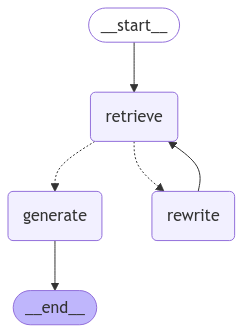

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

context ==[Document(id='8ad52211-d9d2-4cd3-9dcb-6c3796cc24b0', metadata={'source': './documents/income_tax.txt'}, page_content='1. 근속연수에 따라 정한 다음의 금액\n근속연수 | 공제액\n--- | ---\n5년 이하 | 100만원 공제소득\n5년 초과 10년 이하 | 500만원+200만원×(근속연수−5)\n10년 초과 20년 이하 | 1천500만원+250만원×(근속연수−10)\n법제처 | 31 | 국가법령정보센터'), Document(id='dd7fca75-dbaa-4f75-800c-0ecfcbfd3cc7', metadata={'source': './documents/income_tax.txt'}, page_content='1. 근속연수에 따라 정한 다음의 금액\n근속연수 | 공제액\n--- | ---\n5년 이하 | 100만원 공제소득\n5년 초과 10년 이하 | 500만원+200만원×(근속연수−5)\n10년 초과 20년 이하 | 1천500만원+250만원×(근속연수−10)\n법제처 | 31 | 국가법령정보센터'), Document(id='149ce9ed-e14c-4c80-9111-0c2a5c9f33fa', metadata={'source': './documents/income_tax.txt'}, page_content='1. 근속연수에 따라 정한 다음의 금액\n근속연수 | 공제액\n--- | ---\n5년 이하 | 100만원 공제소득\n5년 초과 10년 이하 | 500만원+200만원×(근속연수−5)\n10년 초과 20년 이하 | 1천500만원+250만원×(근속연수−10)\n법제처 | 31 | 국가법령정보센터')]
doc relevence response: {'Score': 0, 'Explanation': "The provided FACTS all revolve around tax deductions based on years of service (근속연수

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT